# Acquisition des données

In [ ]:
# Exercice 1 : Acquisition des données
# M2 MIASHS : projet Network Analysis for Information Retrieval

# Importation des bibliothèques nécessaires
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import re
from datetime import datetime

# Configuration pour afficher plus de colonnes
pd.set_option('display.max_columns', None)


In [3]:
# 1. Chargement des données
def load_citation_network_data(file_path):
    """
    Charge les données du Citation Network Dataset à partir d'un fichier JSON.
    Chaque ligne du fichier contient un article au format JSON.
    
    Args:
        file_path (str): Chemin vers le fichier JSON
        
    Returns:
        list: Liste des articles sous forme de dictionnaires
    """
    articles = []
    
    try:
        # Lecture ligne par ligne (chaque ligne est un JSON indépendant)
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Chargement des articles"):
                try:
                    article = json.loads(line.strip())
                    articles.append(article)
                except json.JSONDecodeError:
                    print(f"Erreur de décodage JSON pour la ligne: {line[:50]}...")
                    continue
        
        print(f"Nombre total d'articles chargés: {len(articles)}")
        return articles
    
    except FileNotFoundError:
        print(f"Le fichier {file_path} n'a pas été trouvé.")
        return []

# 2. Exploration des données
def explore_dataset(articles):
    """
    Explore la structure du jeu de données et affiche des informations générales.
    
    Args:
        articles (list): Liste des articles
    """
    if len(articles) == 0:
        print("Aucun article à explorer.")
        return
    
    # Afficher la structure d'un article
    print("\n2.1. Structure d'un article d'exemple:")
    sample_article = articles[0]
    for key, value in sample_article.items():
        if isinstance(value, list) and len(value) > 3:
            print(f"{key}: {value[:3]} ... (total: {len(value)})")
        else:
            print(f"{key}: {value}")
    
    # Vérifier les clés disponibles
    print("\n2.2. Clés disponibles dans le jeu de données:")
    all_keys = set()
    for article in articles[:1000]:  # Analyse des 1000 premiers pour performance
        all_keys.update(article.keys())
    print(all_keys)
    
    # Calculer la disponibilité des champs
    print("\n2.3. Disponibilité des champs:")
    field_availability = {}
    for key in all_keys:
        count = sum(1 for article in articles if key in article)
        field_availability[key] = (count, count/len(articles)*100)
    
    for key, (count, percentage) in field_availability.items():
        print(f"{key}: {count} articles ({percentage:.2f}%)")

# 3. Conversion en DataFrame
def convert_to_dataframe(articles):
    """
    Convertit la liste d'articles en DataFrame pandas pour faciliter l'analyse.
    
    Args:
        articles (list): Liste des articles
        
    Returns:
        pandas.DataFrame: DataFrame contenant les articles
    """
    # Sélection des champs pertinents
    processed_articles = []
    
    for article in tqdm(articles, desc="Conversion en DataFrame"):
        processed_article = {
            'id': article.get('id', None),
            'title': article.get('title', ''),
            'abstract': article.get('abstract', ''),
            'year': article.get('year', None),
            'venue': article.get('venue', ''),  # Conférence ou journal
            'n_citation': article.get('n_citation', 0),  # Nombre de citations
            'author_count': len(article.get('authors', [])),
            'references_count': len(article.get('references', [])),
        }
        
        # Traitement des auteurs (déjà sous forme de chaînes de caractères dans ce jeu de données)
        authors = article.get('authors', [])
        # Les auteurs sont déjà des chaînes de caractères, pas des dictionnaires
        processed_article['authors'] = authors
        processed_article['author_names'] = ', '.join(authors) if authors else ''
        
        # Stockage des références
        processed_article['references'] = article.get('references', [])
        
        processed_articles.append(processed_article)
    
    df = pd.DataFrame(processed_articles)
    return df

# 4. Analyse statistique de base
def basic_statistics(df):
    """
    Calcule et affiche des statistiques de base sur le jeu de données.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
    """
    print("\n4.1. Informations générales sur le DataFrame:")
    print(df.info())
    
    print("\n4.2. Statistiques descriptives:")
    print(df.describe())
    
    # Distribution par année (devrait être principalement 2015)
    print("\n4.3. Distribution par année:")
    year_counts = df['year'].value_counts().sort_index()
    print(year_counts)
    
    # Top venues (conférences/journaux)
    print("\n4.4. Top 10 des conférences/journaux:")
    venue_counts = df['venue'].value_counts().head(10)
    print(venue_counts)
    
    # Distribution du nombre d'auteurs par article
    print("\n4.5. Statistiques sur le nombre d'auteurs par article:")
    print(df['author_count'].describe())
    
    # Distribution du nombre de références par article
    print("\n4.6. Statistiques sur le nombre de références par article:")
    print(df['references_count'].describe())
    
    # Distribution du nombre de citations reçues
    print("\n4.7. Statistiques sur le nombre de citations reçues:")
    print(df['n_citation'].describe())

# 5. Visualisations de base
def basic_visualizations(df):
    """
    Crée et affiche des visualisations de base pour explorer le jeu de données.
    Adaptée pour l'affichage direct dans Jupyter Notebook.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
    """
    # Configuration pour un meilleur affichage dans Jupyter
    plt.rcParams['figure.figsize'] = (14, 10)
    
    # Figure 1: Statistiques générales
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 5.1. Distribution du nombre d'auteurs par article
    sns.histplot(df['author_count'].clip(0, 10), kde=True, bins=10, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution du nombre d\'auteurs par article', fontsize=12)
    axes[0, 0].set_xlabel('Nombre d\'auteurs')
    axes[0, 0].set_ylabel('Nombre d\'articles')
    
    # 5.2. Distribution du nombre de références par article
    sns.histplot(df['references_count'].clip(0, 50), kde=True, bins=20, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution du nombre de références par article', fontsize=12)
    axes[0, 1].set_xlabel('Nombre de références')
    axes[0, 1].set_ylabel('Nombre d\'articles')
    
    # 5.3. Distribution du nombre de citations
    sns.histplot(df['n_citation'].clip(0, 50), kde=True, bins=20, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution du nombre de citations reçues', fontsize=12)
    axes[1, 0].set_xlabel('Nombre de citations')
    axes[1, 0].set_ylabel('Nombre d\'articles')
    
    # 5.4. Top 10 des conférences/journaux
    top_venues = df['venue'].value_counts().head(10)
    sns.barplot(x=top_venues.values, y=top_venues.index, ax=axes[1, 1])
    axes[1, 1].set_title('Top 10 des conférences/journaux', fontsize=12)
    axes[1, 1].set_xlabel('Nombre d\'articles')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Auteurs les plus prolifiques
    plt.figure(figsize=(12, 8))
    all_authors = [author for sublist in df['authors'] for author in sublist]
    top_authors = Counter(all_authors).most_common(20)
    author_df = pd.DataFrame(top_authors, columns=['Auteur', 'Nombre d\'articles'])
    sns.barplot(x='Nombre d\'articles', y='Auteur', data=author_df)
    plt.title('Top 20 des auteurs les plus prolifiques', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Visualisations affichées directement dans le notebook")

# 6. Enregistrement des données traitées
def save_processed_data(df, output_file):
    """
    Enregistre les données traitées pour une utilisation ultérieure.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles traités
        output_file (str): Chemin du fichier de sortie
    """
    print(f"\nEnregistrement des données traitées dans {output_file}")
    df.to_pickle(output_file)
    print(f"Données enregistrées avec succès. Shape: {df.shape}")


## Chargement des données

In [4]:
# 1. Chargement des données
# Chemin vers le fichier de données (à adapter selon votre configuration)
input_file = "dblp.v10/dblp-ref/dblp-ref-3.json"
output_file = "articles_processed.pkl"

print("1. Chargement des données...")
articles = load_citation_network_data(input_file)

1. Chargement des données...


Chargement des articles: 0it [00:00, ?it/s]

Chargement des articles: 79007it [00:01, 44130.03it/s]

Nombre total d'articles chargés: 79007


## Exploration des données

In [5]:
# 2. Exploration des données
print("\n2. Exploration des données...")
explore_dataset(articles)


2. Exploration des données...

2.1. Structure d'un article d'exemple:
abstract: AdaBoost algorithm based on Haar-like features can achieves high accuracy (above 95%) in object detection. Meanwhile massive computing power is needed to implement the cascaded classifiers involved in AdaBoost detection. To solve this problem, several dedicated hardware solutions have been proposed for real-time applications. In this work, a novel heterogeneous architecture of an AdaBoost detector is presented. This architecture achieves higher performance while consuming fewer hardware resources. By combining an integrated ARM Cortex-A9 processor with a dedicated accelerator, this architecture can be configured to realize various objects detection by simply loading different parameters. 2-D parallelism is involved in accelerator unit combination which brings more flexibility. This scheme is implemented on Xilinx ZC702 platform, the experiment result shows that 40 QVGA frames per second can be achieved for

## Conversion en DataFrame

In [6]:
# 3. Conversion en DataFrame
print("\n3. Conversion en DataFrame...")
df = convert_to_dataframe(articles)


3. Conversion en DataFrame...


Conversion en DataFrame: 100%|██████████| 79007/79007 [00:01<00:00, 74016.74it/s] 


## Analyse statistique de base

In [7]:
# 4. Analyse statistique de base
print("\n4. Analyse statistique de base...")
basic_statistics(df)


4. Analyse statistique de base...

4.1. Informations générales sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79007 entries, 0 to 79006
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                79007 non-null  object
 1   title             79007 non-null  object
 2   abstract          79007 non-null  object
 3   year              79007 non-null  int64 
 4   venue             79007 non-null  object
 5   n_citation        79007 non-null  int64 
 6   author_count      79007 non-null  int64 
 7   references_count  79007 non-null  int64 
 8   authors           79007 non-null  object
 9   author_names      79007 non-null  object
 10  references        79007 non-null  object
dtypes: int64(4), object(7)
memory usage: 6.6+ MB
None

4.2. Statistiques descriptives:
               year    n_citation  author_count  references_count
count  79007.000000  79007.000000  79007.000000      7900

## Visualisations de base


5. Visualisations de base...


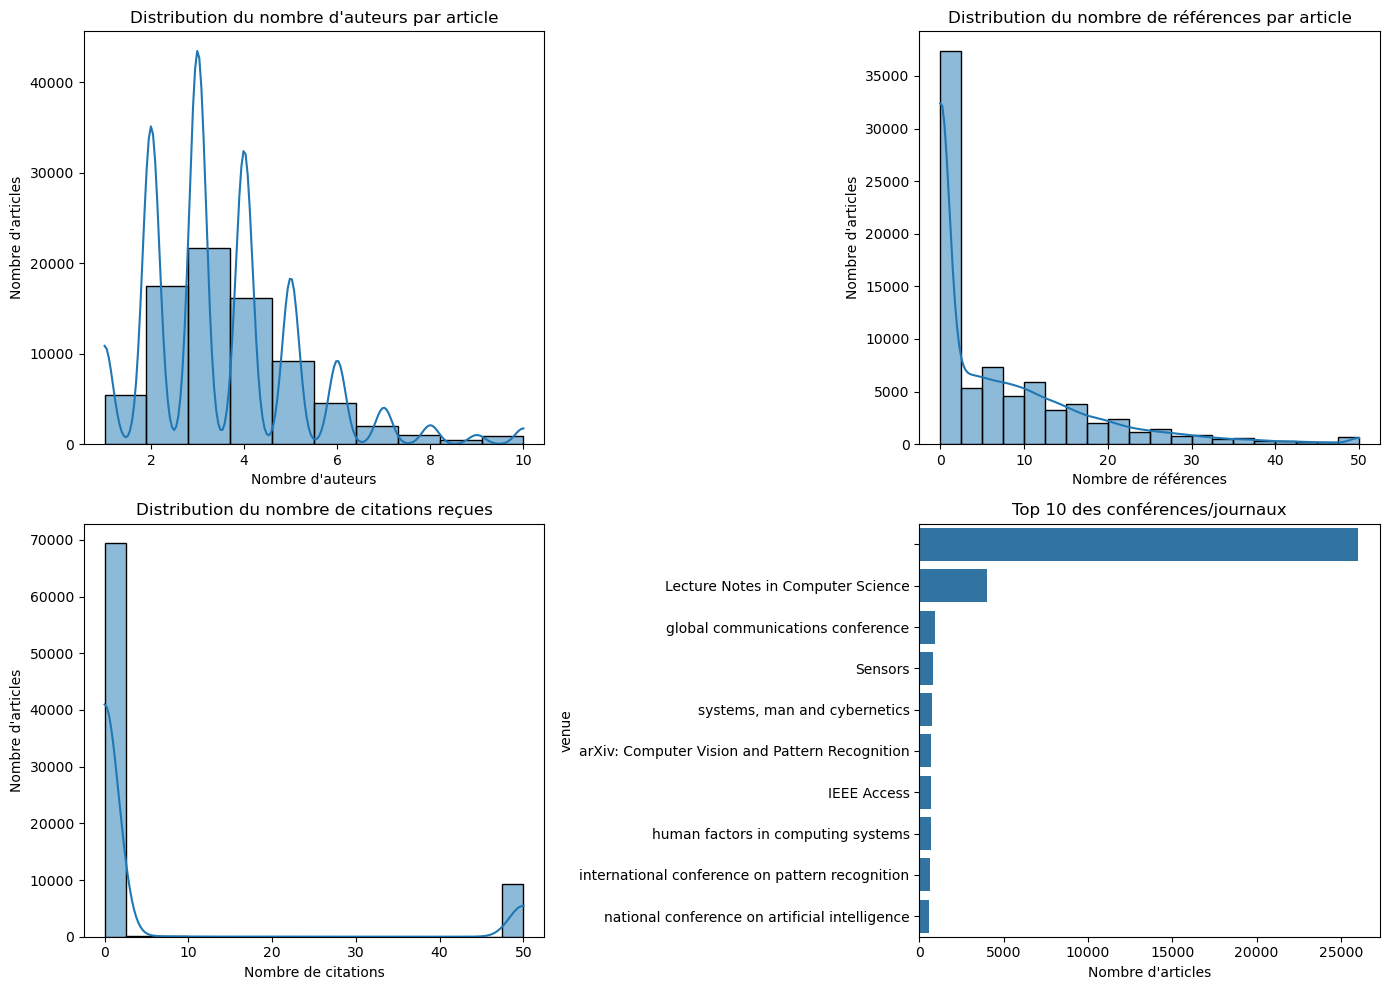

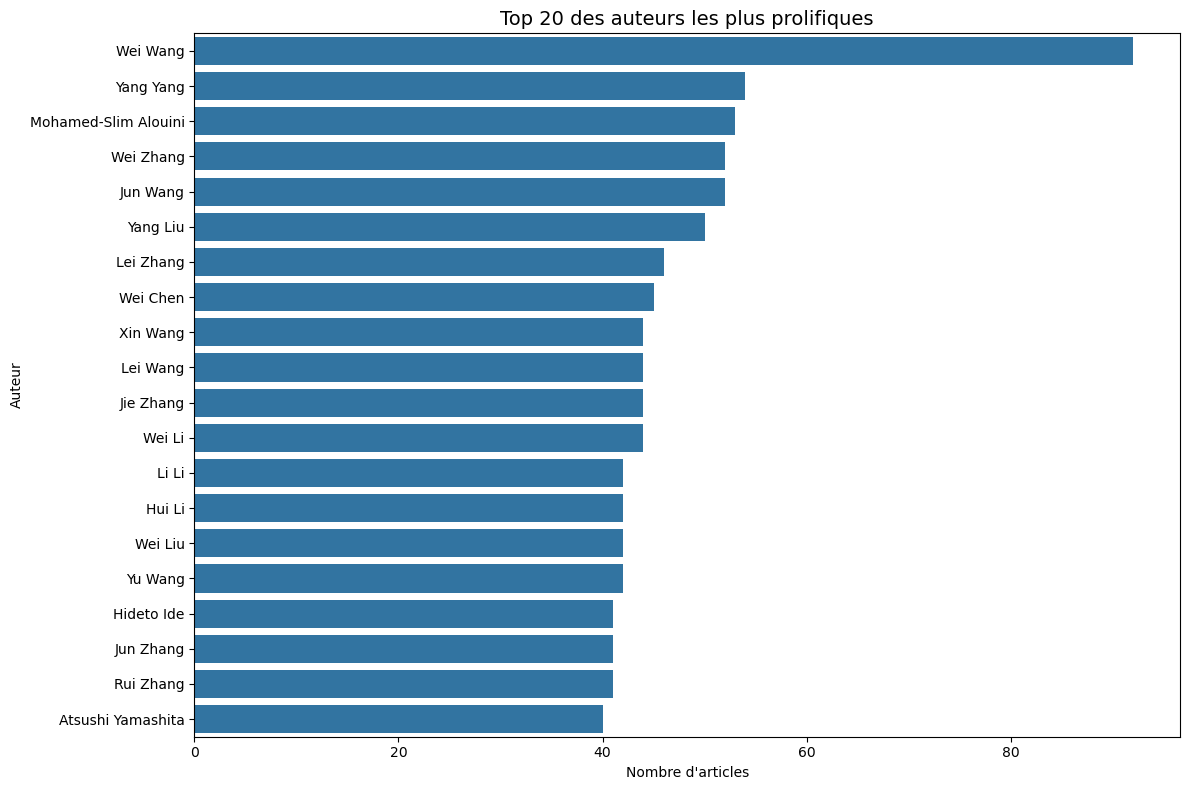

Visualisations affichées directement dans le notebook


In [8]:
# 5. Visualisations de base
print("\n5. Visualisations de base...")
basic_visualizations(df)

## Enregistrement des données traitées

In [9]:
# 6. Enregistrement des données traitées
output_file = "articles_processed.pkl"
print("\n6. Enregistrement des données traitées...")
save_processed_data(df, output_file)


6. Enregistrement des données traitées...

Enregistrement des données traitées dans articles_processed.pkl
Données enregistrées avec succès. Shape: (79007, 11)
